In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


- Load the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


- No missing values

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

- Transform the 'date' attribute to datetime data type

In [5]:
{column: len(df[column].unique()) for column in df.columns}

{'date': 1826, 'store': 10, 'item': 50, 'sales': 213}

- Dataset includes 50 items from 10 stores

In [6]:
print('- Data collection from', df['date'].min(), 'to', df['date'].max())

- Data collection from 2013-01-01 00:00:00 to 2017-12-31 00:00:00


In [7]:
df_train = df[df['store']==1]
df_train = df_train[df_train['item']==1]

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.dayofyear
df_train['weekday'] = df_train['date'].dt.weekday

df_train

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,361,2
1822,2017-12-28,1,1,19,2017,12,362,3
1823,2017-12-29,1,1,15,2017,12,363,4
1824,2017-12-30,1,1,27,2017,12,364,5


- Only item 1 sold in stroe 1 considered for analysis

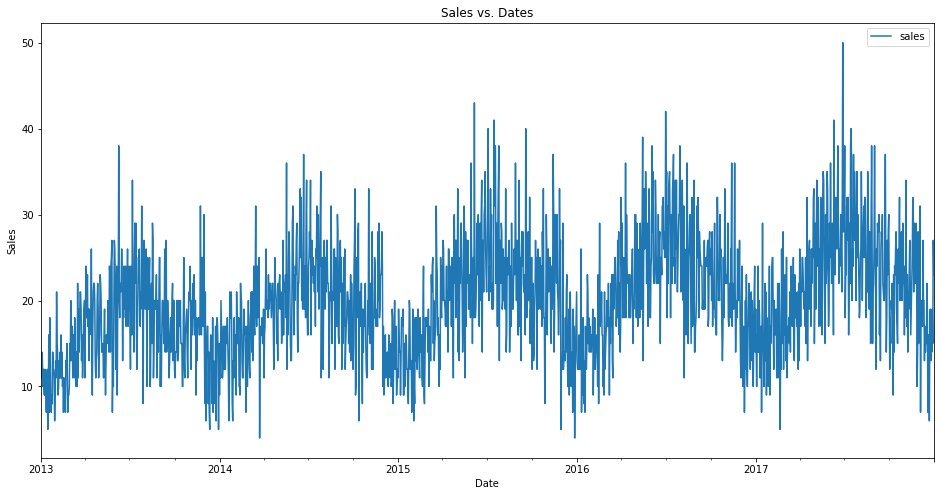

In [8]:
df_train.plot('date', 'sales', figsize=(16, 8))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales vs. Dates')
plt.show();

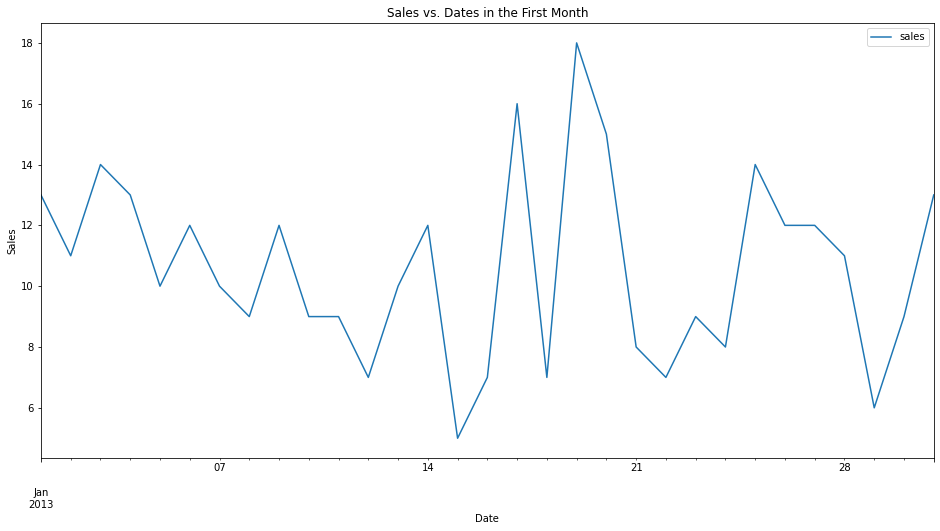

In [9]:
df_train[:31].plot('date', 'sales', figsize=(16, 8))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales vs. Dates in the First Month')
plt.show();

- Upward trend in sales over the years
- Seasonal pattern identified, with mid-year as sales peak

In [10]:
day_0 = df_train[df_train['weekday']==0]['sales']
day_1 = df_train[df_train['weekday']==1]['sales']
day_2 = df_train[df_train['weekday']==2]['sales']
day_3 = df_train[df_train['weekday']==3]['sales']
day_4 = df_train[df_train['weekday']==4]['sales']
day_5 = df_train[df_train['weekday']==5]['sales']
day_6 = df_train[df_train['weekday']==6]['sales']

data = [day_0, day_1, day_2, day_3, day_4, day_5, day_6]
label = ['day 0', 'day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6']

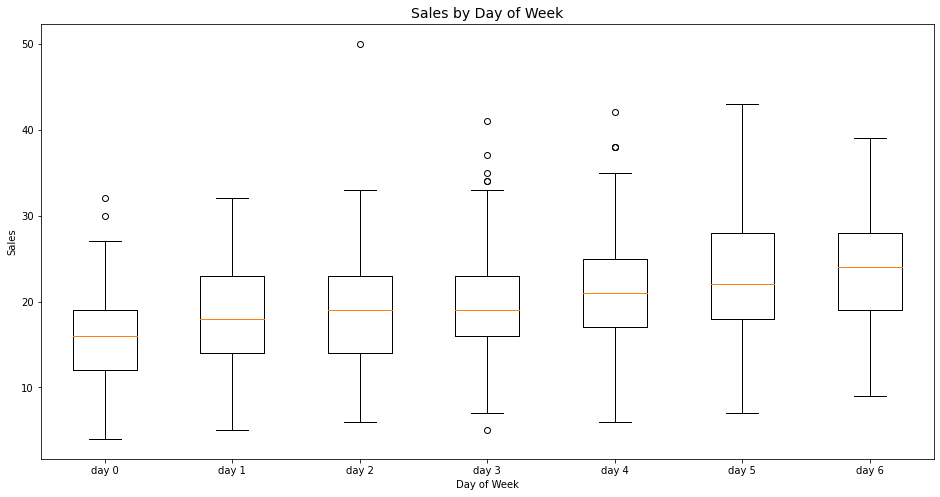

In [11]:
plt.figure(figsize=(16,8))
plt.boxplot(data, labels=label)
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.title('Sales by Day of Week', fontsize=14)
plt.show();

- Higher sales on Friday and Saturday (day 5 and day 6), Sunday with lowest sales
- Outliers on Tuesday, Wednesday and Thursday

In [12]:
df_train = df_train.set_index('date')
df_train['sales'] = df_train['sales'].astype(float)

df_train.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 432x288 with 0 Axes>

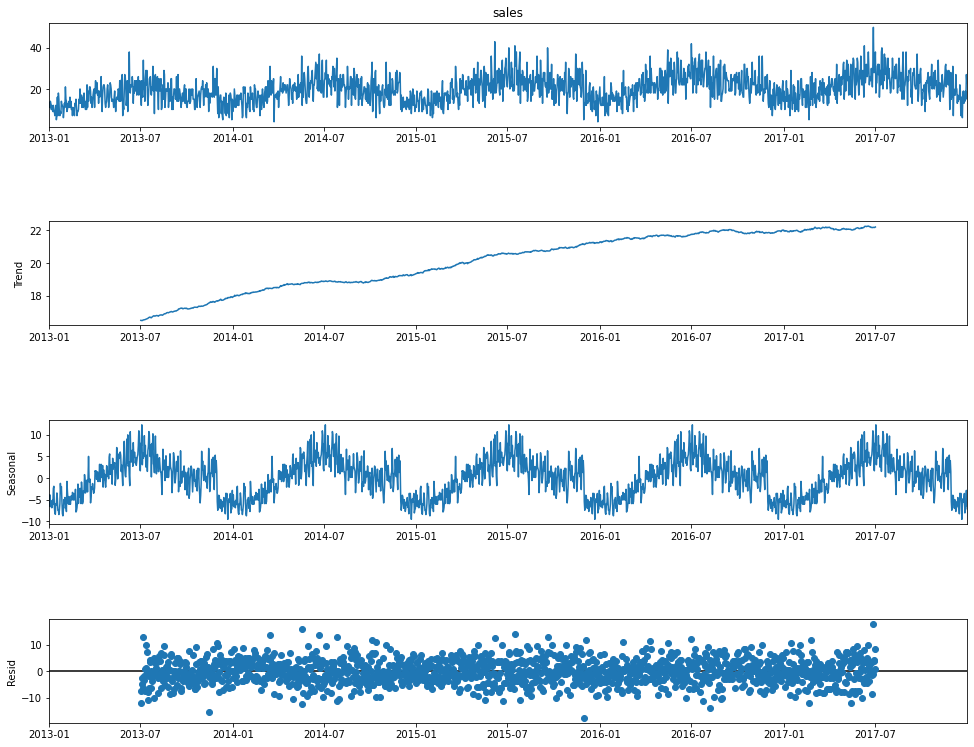

In [13]:
seasonal = seasonal_decompose(df_train['sales'], model='additive', freq=365)

fig = plt.figure()
fig = seasonal.plot()
fig.set_size_inches(15, 12)
plt.show();

- As there is a upward trend, the data is not considered stationary

_"When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable."_

In [14]:
def test_stationarity(timeseries, window = 12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 8))
    orig = plt.plot(timeseries, color='tab:blue',label='Original')
    mean = plt.plot(rolmean, color='tab:orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='tab:green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    
    print(dfoutput)

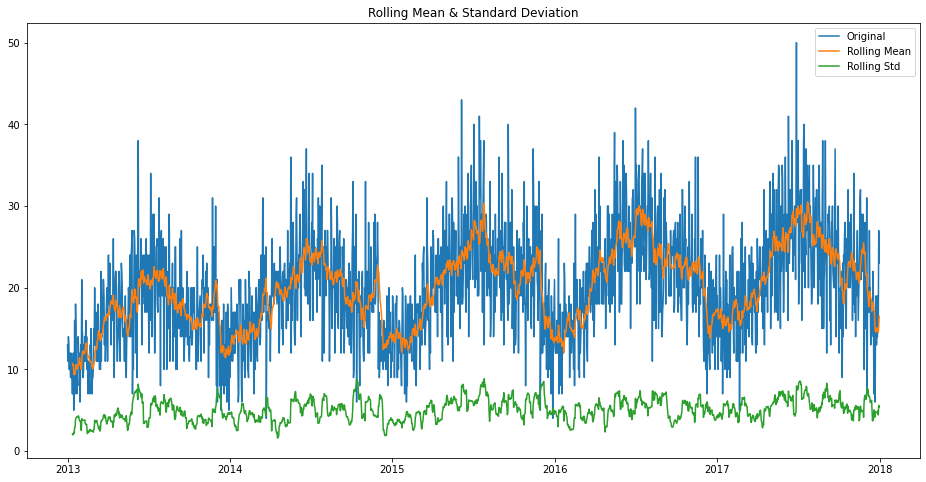

Results of Dickey-Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [15]:
test_stationarity(df_train['sales'])

- Dickey-Fuller Test for dataset stationarity
- p-valuie is smaller than sigfinicance level of 5%, but there is obviously an upward trend
- Test Statistic -3.158 is larger than critical value at 1% (-3.434)
- The data is not stationary

In [16]:
df_train['sales_shift'] = df_train.sales.shift(1)
df_train['first_diff'] = df_train.sales - df_train.sales_shift
df_first_diff = df_train['first_diff']
df_first_diff = df_first_diff.dropna()

- Create a "first_diff" data set with 1 time differencing

In [17]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

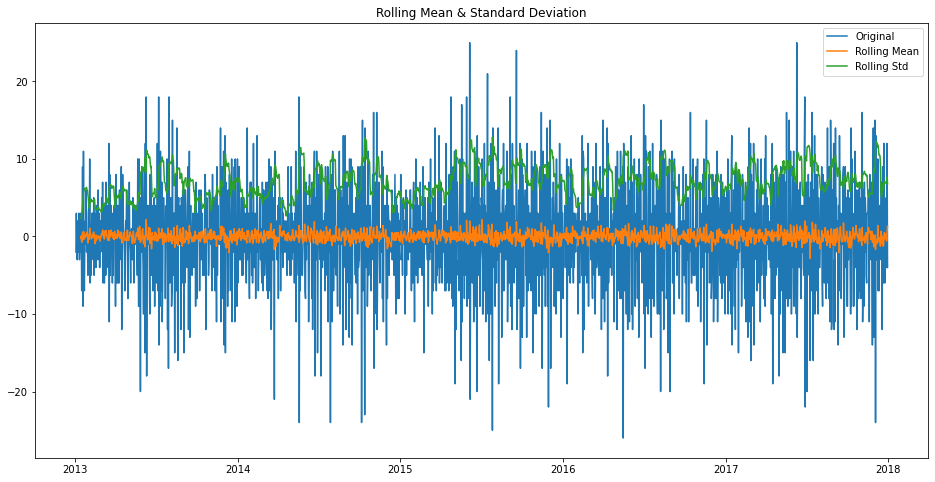

Results of Dickey-Fuller Test:
Test Statistic                 -12.677
p-value                          0.000
#Lags Used                      22.000
Number of Observations Used   1802.000
Critical Value (1%)             -3.434
Critical Value (5%)             -2.863
Critical Value (10%)            -2.568
dtype: float64


In [18]:
test_stationarity(df_first_diff)

- p-value smaller than significance level of 5% for the "first_diff" dataset
- Test Statistic (-12.677) is smaller than critical value at 1% (-3.434). This suggests that we can reject the null hypothesis with a significance level of less than 1% 
- Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. df_first_diff is likely to be staionary now

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Original Data')

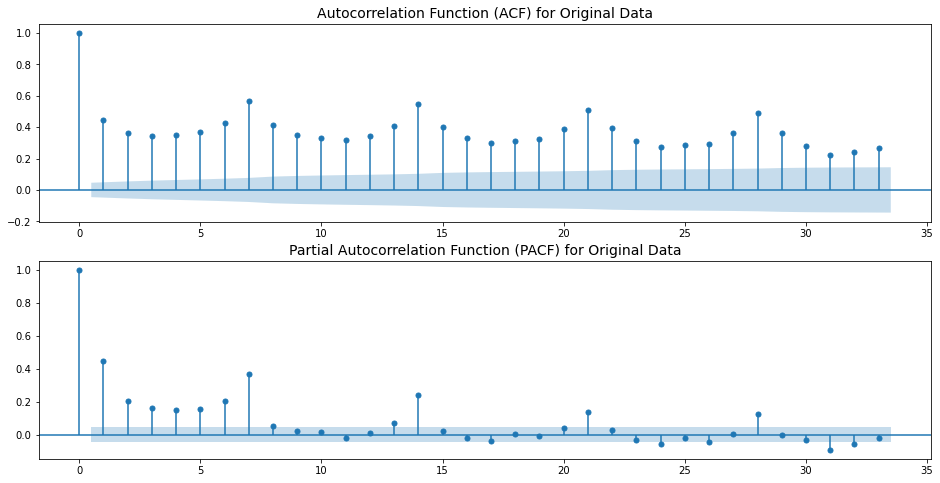

In [19]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train.sales, ax=ax1)
plt.title('Autocorrelation Function (ACF) for Original Data', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train.sales, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF) for Original Data', fontsize=14)

- ACF and PACF plot for origina data
- Here we can see the ACF and PACF both has a recurring pattern every 7 periods, indicating the existance of a weekly pattern. 
- SARIMA would be considered as there is a significant seasonal pattern

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Data with 1 Differencing')

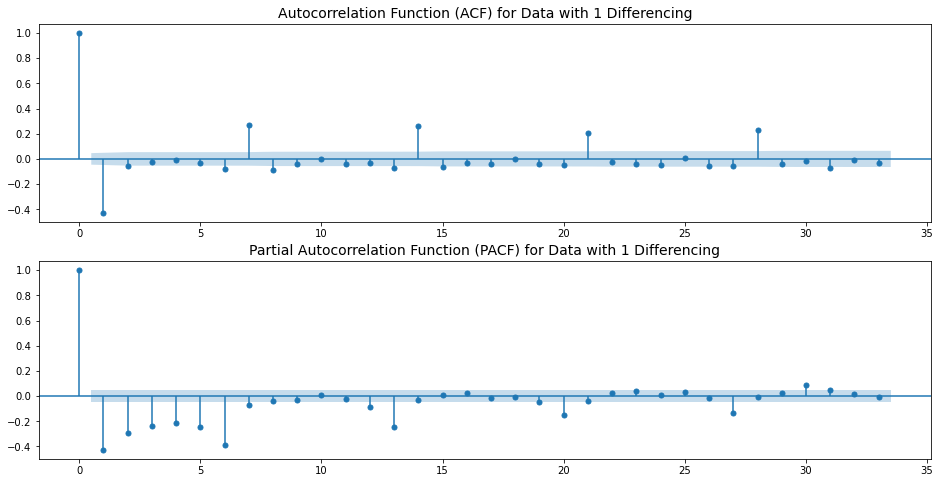

In [20]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_first_diff, ax=ax1)
plt.title('Autocorrelation Function (ACF) for Data with 1 Differencing', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_first_diff, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF) for Data with 1 Differencing', fontsize=14)

- ACF and PACF plot for data with 1 differencing
- For ACF, there is significant

## Model Building

- p set to value of 6, as suggested in PACF plot
- d set to value of 1, as the data reaches stationarity after 1 differencing applied
- To avoid the potential for incorrectly specifying the value of q (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF

### 610 Model

In [21]:
arima_mod610 = sm.tsa.ARIMA(df_train.sales, order=(6,1,0)).fit()
print(arima_mod610.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Sun, 24 Jan 2021   AIC                          11211.335
Time:                        21:12:31   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

- AIC: 11211.334
- BIC: 11255.41
- Almost all of the 6 lags for AR are with fairly large coefficient and low p-value

In [22]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod610.resid
print(normaltest(resid))

NormaltestResult(statistic=16.426389884601825, pvalue=0.00027105333663438567)


- p value is rather small, suggesting the residual is not normally distributed

<AxesSubplot:xlabel='date'>

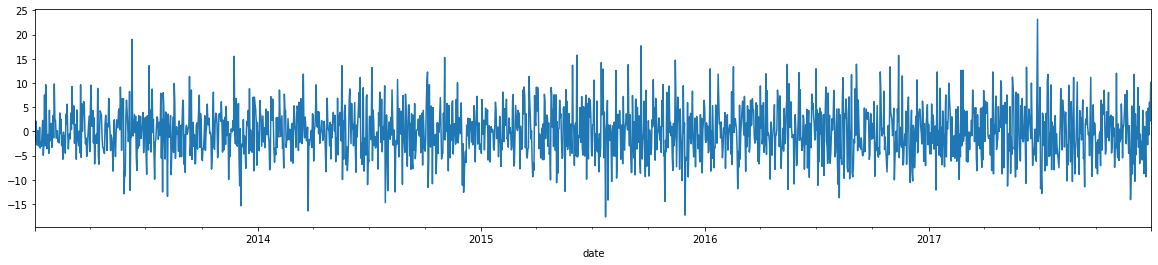

In [23]:
plt.figure(figsize=(20,4))
resid.plot()

<AxesSubplot:ylabel='Density'>

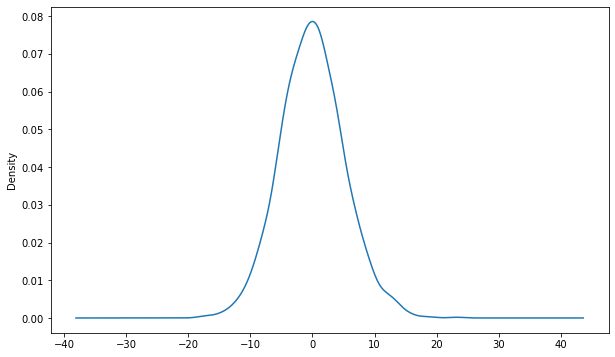

In [24]:
plt.figure(figsize=(10,6))
resid.plot(kind='kde')

In [25]:
print(resid.describe())

count   1825.000
mean      -0.001
std        5.197
min      -17.665
25%       -3.470
50%       -0.112
75%        3.329
max       23.190
dtype: float64


- A non-zero mean in the residuals, indicating bias in the prediction

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Residual of Model610')

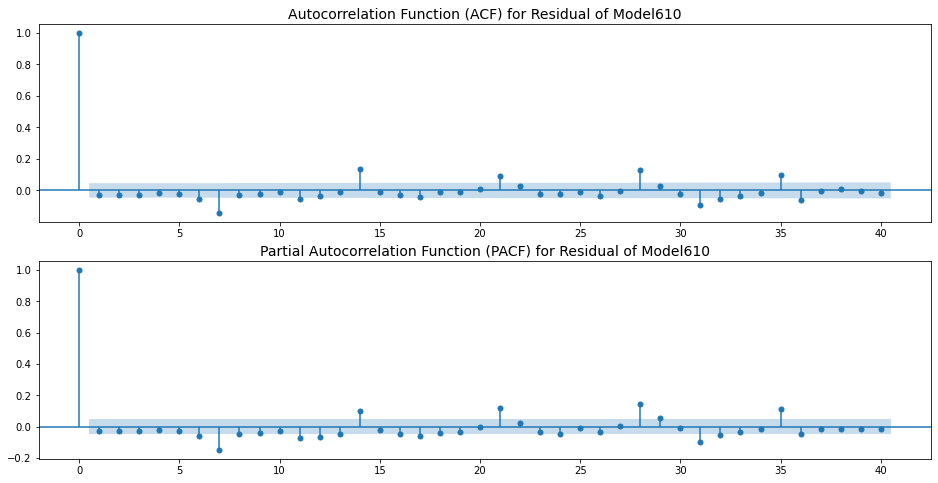

In [26]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod610.resid, lags=40, ax=ax1)
plt.title('Autocorrelation Function (ACF) for Residual of Model610', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod610.resid, lags=40, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF) for Residual of Model610', fontsize=14)

- There is still some pattern in residual of model610

### 611 Model

In [31]:
arima_mod611 = sm.tsa.ARIMA(df_train.sales, order=(6,1,1)).fit(disp=0)
print(arima_mod611.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5592.108
Method:                       css-mle   S.D. of innovations              5.179
Date:                Sun, 24 Jan 2021   AIC                          11202.216
Time:                        21:18:46   BIC                          11251.800
Sample:                    01-02-2013   HQIC                         11220.507
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0038      0.023      0.166      0.868      -0.041       0.049
ar.L1.D.sales    -0.6344      0.059    -10.801      0.000      -0.750      -0.519
ar.L2.D.sales    -0.6173      0.047    -

- AIC: 11202.216
- BIC: 11251.8
- Almost all of the 6 lags for AR  and the 1 lag for MA are with fairly large coefficient and low p-value
- The 611 model has btter AIC and BIC values

In [32]:
resid = arima_mod611.resid
print(normaltest(resid))

NormaltestResult(statistic=14.314843572417892, pvalue=0.0007790605508172397)


Text(0.5, 0, 'Date')

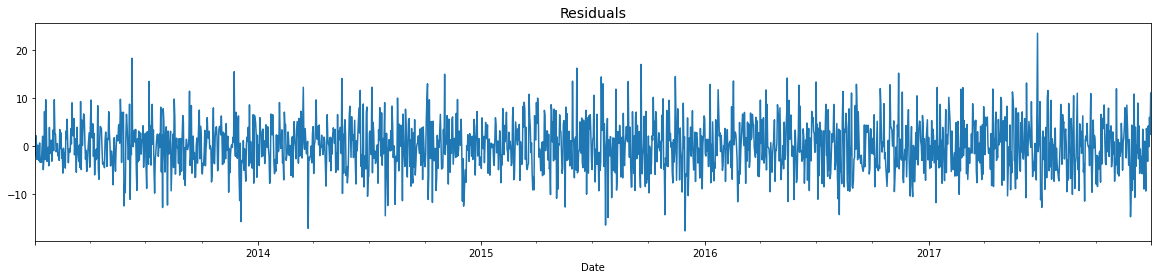

In [40]:
plt.figure(figsize=(20,4))
resid.plot()
plt.title('Residuals', fontsize=14)
plt.xlabel('Date')

Text(0, 0.5, 'Density')

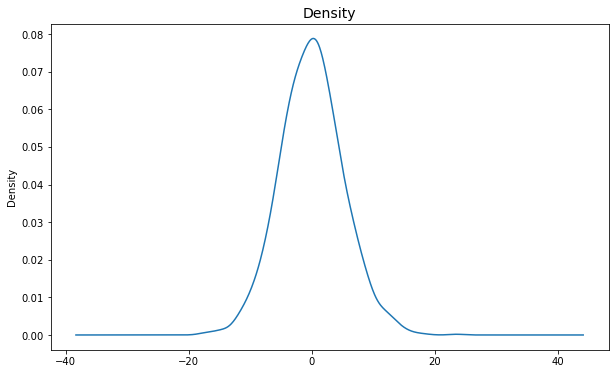

In [41]:
plt.figure(figsize=(10,6))
resid.plot(kind='kde')
plt.title('Density', fontsize=14)
plt.ylabel('Density')

In [35]:
print(resid.describe())

count   1825.000
mean      -0.002
std        5.181
min      -17.737
25%       -3.511
50%       -0.070
75%        3.246
max       23.523
dtype: float64


Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Residual of Model611')

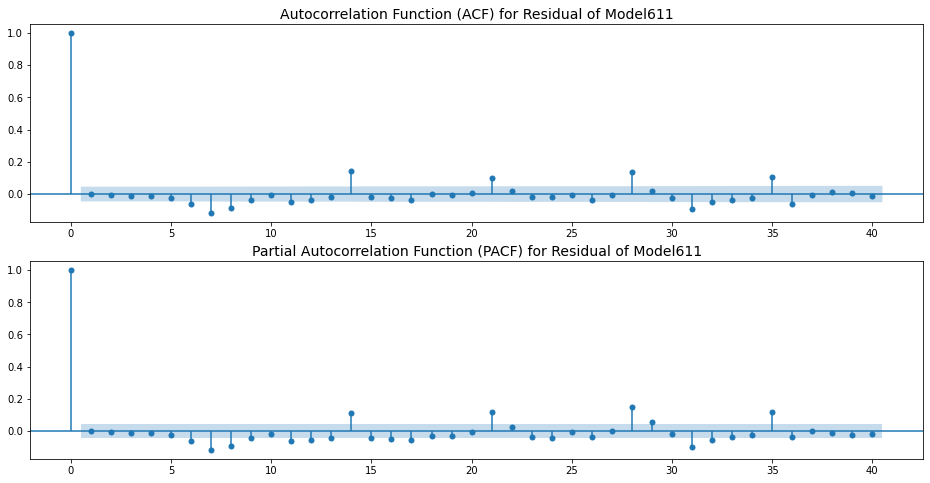

In [36]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod611.resid, lags=40, ax=ax1)
plt.title('Autocorrelation Function (ACF) for Residual of Model611', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod611.resid, lags=40, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF) for Residual of Model611', fontsize=14)

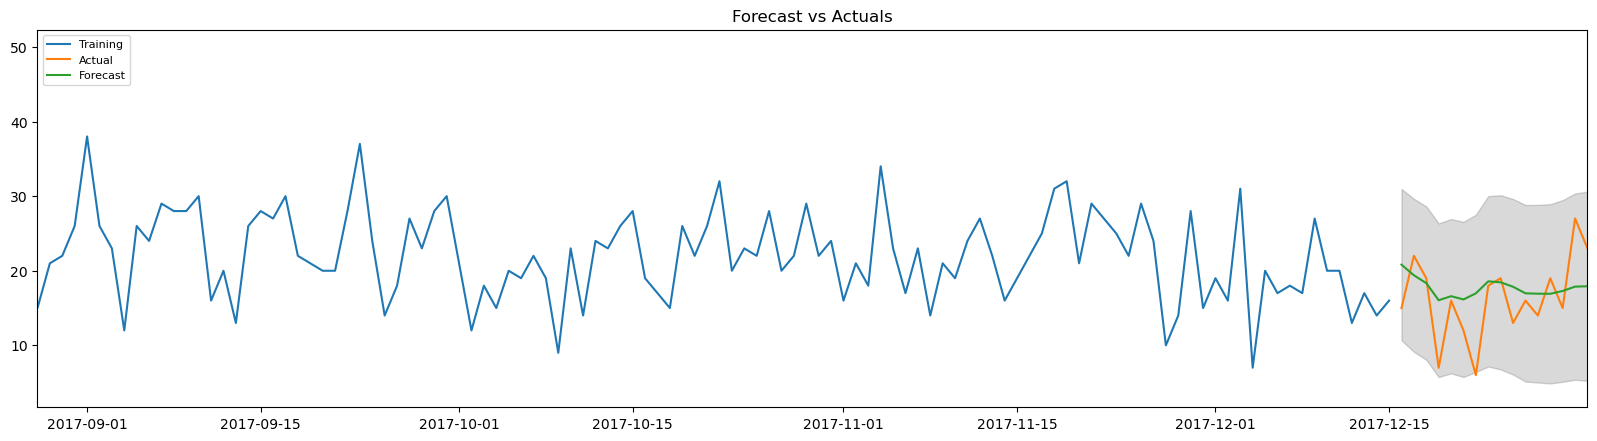

In [84]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df_train['sales'][:1810]
test = df_train['sales'][1810:]

# Build Model
model = ARIMA(train, order=(6, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(16, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(20,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.xlim(df_train.index[1700],df_train.index[1825])
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Grid Search for ARIMA Hyperparameters

- Both 610 and 611 models are tested, but neither seems to be clearly better than other
- For smaller data or when computation capability allows, grid search can be used to help find the best hyperparameters *p, q*

In [ ]:
# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     X = X.astype('float32')
#     train_size = int(len(X) * 0.50)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     # make predictions
#     predictions = list()
    
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])

#     # calculate out of sample error
#     rmse = sqrt(mean_squared_error(test, predictions))
#     return rmse
 
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     rmse = evaluate_arima_model(dataset, order)
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,rmse))
#                 except:
#                     continue
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# # load dataset
# series = df['sales'].values

# # evaluate parameters
# p_values = range(0,13)
# d_values = range(0, 2)
# q_values = range(0, 13)
# warnings.filterwarnings("ignore")
# evaluate_models(series, p_values, d_values, q_values)


### Auto Arima

### Consideration of SARIMA

In [ ]:
sarima_mod610 = sm.tsa.statespace.SARIMAX(df_train.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod610.summary())

In [ ]:
resid = sarima_mod610.resid
print(normaltest(resid))

In [ ]:
fig = plt.figure(figsize=(16,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid, fit = stats.norm, ax = ax0) # need to import scipy.

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

In [ ]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod610.resid, lags=40, ax=ax1)
plt.title('Autocorrelation Function (ACF) for Residual of Model610 with SARIMA', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod610.resid, lags=40, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF) for Residual of Model610 with SARIMA', fontsize=14)

## Using SARIMA Model to Make Prediction

- Using last 90 days as validation data

In [ ]:
start_index = 1730
end_index = 1826
df_train['forecast'] = sarima_mod610.predict(start = start_index, end= end_index, dynamic= True)  
df_train[start_index:end_index][['sales', 'forecast']].plot(figsize=(16, 8))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Prediction of Sales with SARIMA Model', fontsize=14)
plt.show();

In [ ]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [ ]:
smape_kun(df_train[1730:1825]['sales'],df_train[1730:1825]['forecast'])